# Layer 4: Contextual Irregularity Analysis

**Scientific Objective:** Prove the effectiveness of the contextual pipeline in identifying sub-threshold morphological deviations through manifold outlier detection.

**PhD-Level Narrative Enhancements:**
1. **Defect Fingerprinting:** Using Radar Plots to show high-dimensional expansion of outliers.
2. **Sigma Deviations:** Quantifying irregularity via Z-score heatmaps relative to the 'Good' population.
3. **Population Spectrum:** Visualizing the anomaly tail through Cumulative Distribution Functions (CDF).

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from math import pi
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
from scipy import ndimage

# Import module functions
from layered_clustering import (
    load_tiles, extract_center_intensity, extract_darkness_area, extract_stitching_features,
    extract_rotation_symmetry, extract_neighbor_deviation, extract_anisotropy, 
    extract_curvature_irregularity, extract_radial_deviation, cluster_layer
)

np.random.seed(42)
plt.rcParams.update({
    'font.size': 11, 
    'figure.dpi': 150,
    'axes.titleweight': 'bold',
    'axes.titlesize': 14,
    'savefig.bbox': 'tight'
})

RESULTS_DIR = Path('results')
RESULTS_DIR.mkdir(exist_ok=True)
PALETTE = {'Irregular': '#e74c3c', 'Good': '#27ae60'}

## 1. Pipeline Execution (Layers 1-3 Filter)

In [ ]:
print("Isolating sub-threshold population...")
BASE_DIR = Path('.')
META_ATOMS_DIR = BASE_DIR / 'Meta_Atoms'
tiles = load_tiles(META_ATOMS_DIR)
current_tiles = tiles.copy()

# Sequential Peeling (Layers 1-3)
X1 = extract_center_intensity(current_tiles)
res1 = cluster_layer(current_tiles, X1, 'l1')
current_tiles = [current_tiles[i] for i in res1.remaining_indices]

X2 = extract_darkness_area(current_tiles)
res2 = cluster_layer(current_tiles, X2, 'l2')
current_tiles = [current_tiles[i] for i in res2.remaining_indices]

X3 = extract_stitching_features(current_tiles)
res3 = cluster_layer(current_tiles, X3, 'l3')
current_tiles = [current_tiles[i] for i in res3.remaining_indices]

print(f"Processing {len(current_tiles)} pillars in Contextual Manifold.")

Isolating sub-threshold population...


c:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
c:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Processing 1115 pillars in Contextual Manifold.


c:\Users\srfdyz\.conda\envs\ci\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


## 2. Feature Extraction & Outlier Scoring

In [ ]:
print("Characterizing contextual features...")
X_rot = extract_rotation_symmetry(current_tiles)[:, [0]] # Asym
X_neigh = extract_neighbor_deviation(current_tiles)[:, [-1]] # Norm
X_aniso = extract_anisotropy(current_tiles)[:, [0]] # Aniso
X_curv = extract_curvature_irregularity(current_tiles)[:, [0]] # Kurtosis
X_rad = extract_radial_deviation(current_tiles)[:, [0]] # Norm

X_contextual = np.hstack([X_rot, X_neigh, X_aniso, X_curv, X_rad])
cols = ['Rotation_Asym', 'Neighbor_Dev', 'Anisotropy', 'Curvature_Kurt', 'Radial_Dev']

# Outlier Scoring
scaler = StandardScaler()
X_norm = scaler.fit_transform(np.nan_to_num(X_contextual))
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
lof_labels = lof.fit_predict(X_norm)
lof_scores = -lof.negative_outlier_factor_

df = pd.DataFrame(X_contextual, columns=cols)
df['LOF'] = lof_scores
df['Label'] = ['Irregular' if l == -1 else 'Good' for l in lof_labels]
n_irr = sum(lof_labels == -1)

Characterizing contextual features...


## Plot 1: The Outlier Manifold (t-SNE Overview)
**Narrative:** Good pillars form a dense core; Irregular pillars exist on the sparse, high-dimensional fringe.

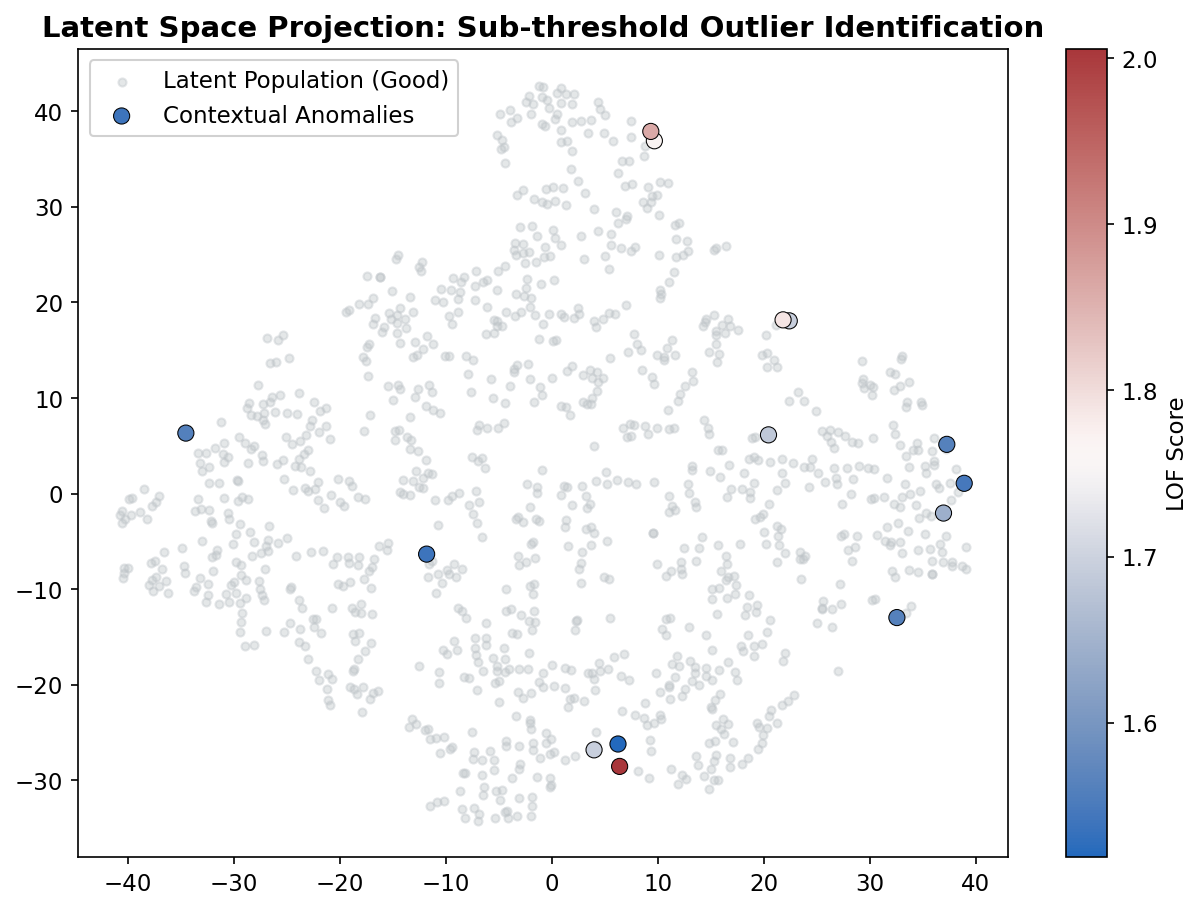

In [ ]:
tsne = TSNE(2, perplexity=min(30, len(df)-1), random_state=42)
X_tsne = tsne.fit_transform(X_norm)

plt.figure(figsize=(10, 7))
good = df['Label'] == 'Good'
plt.scatter(X_tsne[good, 0], X_tsne[good, 1], c='#bdc3c7', alpha=0.4, s=15, label='Latent Population (Good)')
sc = plt.scatter(X_tsne[~good, 0], X_tsne[~good, 1], c=df.loc[~good, 'LOF'], 
                 cmap='vlag', s=60, edgecolors='black', linewidth=0.5, label='Contextual Anomalies')
plt.colorbar(sc, label='LOF Score')
plt.legend(frameon=True, facecolor='white', framealpha=0.9)
plt.title('Latent Space Projection: Sub-threshold Outlier Identification')
plt.savefig(RESULTS_DIR / 'layer4_tsne_manifold.png')
plt.show()

## Plot 2: Defect Fingerprints (Radar Analysis)
**Narrative:** Contrasting the 'Universal Average Good' against specific high-score outliers reveals the nature of the irregularity.

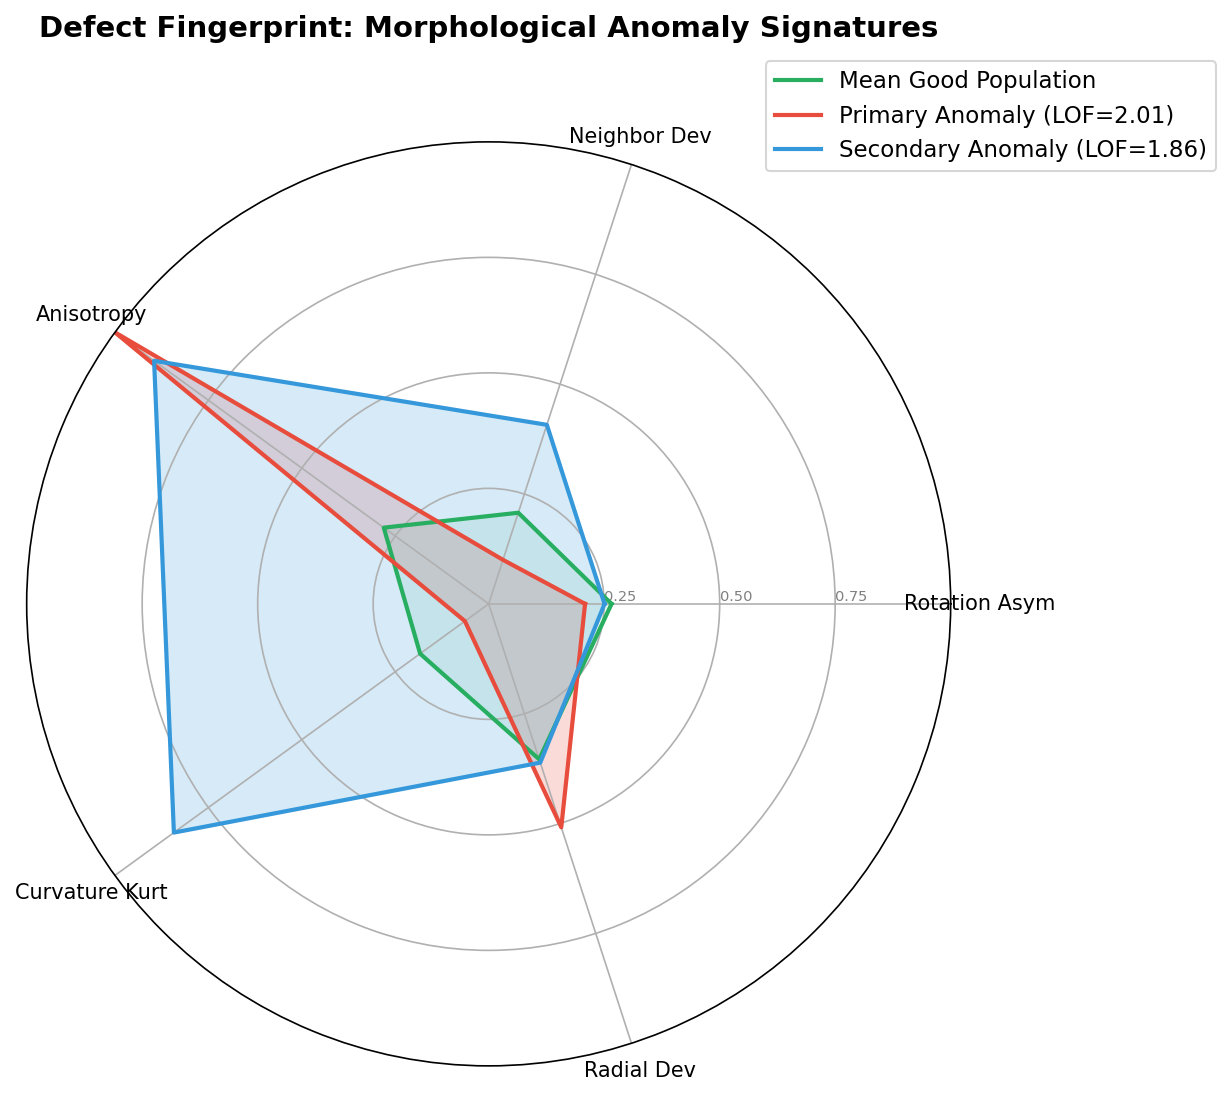

In [ ]:
def render_radar(df, idxs, names, colors):
    # Max-scale for visualization transparency
    data = df[cols].copy()
    data = (data - data.min()) / (data.max() - data.min() + 1e-10)
    avg_good = data[df['Label'] == 'Good'].mean()
    
    categories = [c.replace('_', ' ') for c in cols]
    N = len(categories)
    angles = [n/float(N)*2*pi for n in range(N)]
    angles += angles[:1]
    
    fig = plt.figure(figsize=(10, 8), dpi=150)
    ax = fig.add_subplot(111, polar=True)
    
    # Base Good Population
    v_good = avg_good.tolist(); v_good += v_good[:1]
    ax.plot(angles, v_good, color='#27ae60', linewidth=2, label='Mean Good Population')
    ax.fill(angles, v_good, color='#27ae60', alpha=0.1)
    
    # Specific Outliers
    for idx, name, col in zip(idxs, names, colors):
        vals = data.iloc[idx].tolist(); vals += vals[:1]
        ax.plot(angles, vals, color=col, linewidth=2, label=f"{name} (LOF={df.iloc[idx]['LOF']:.2f})")
        ax.fill(angles, vals, color=col, alpha=0.2)
        
    plt.xticks(angles[:-1], categories, size=10)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.50", "0.75"], color="grey", size=7)
    plt.ylim(0, 1)
    plt.title('Defect Fingerprint: Morphological Anomaly Signatures', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.savefig(RESULTS_DIR / 'layer4_radar_fingerprints.png')
    plt.show()

# Find top and second top outliers for contrast
top_2 = df['LOF'].nlargest(2).index
render_radar(df, top_2, ['Primary Anomaly', 'Secondary Anomaly'], ['#e74c3c', '#3498db'])

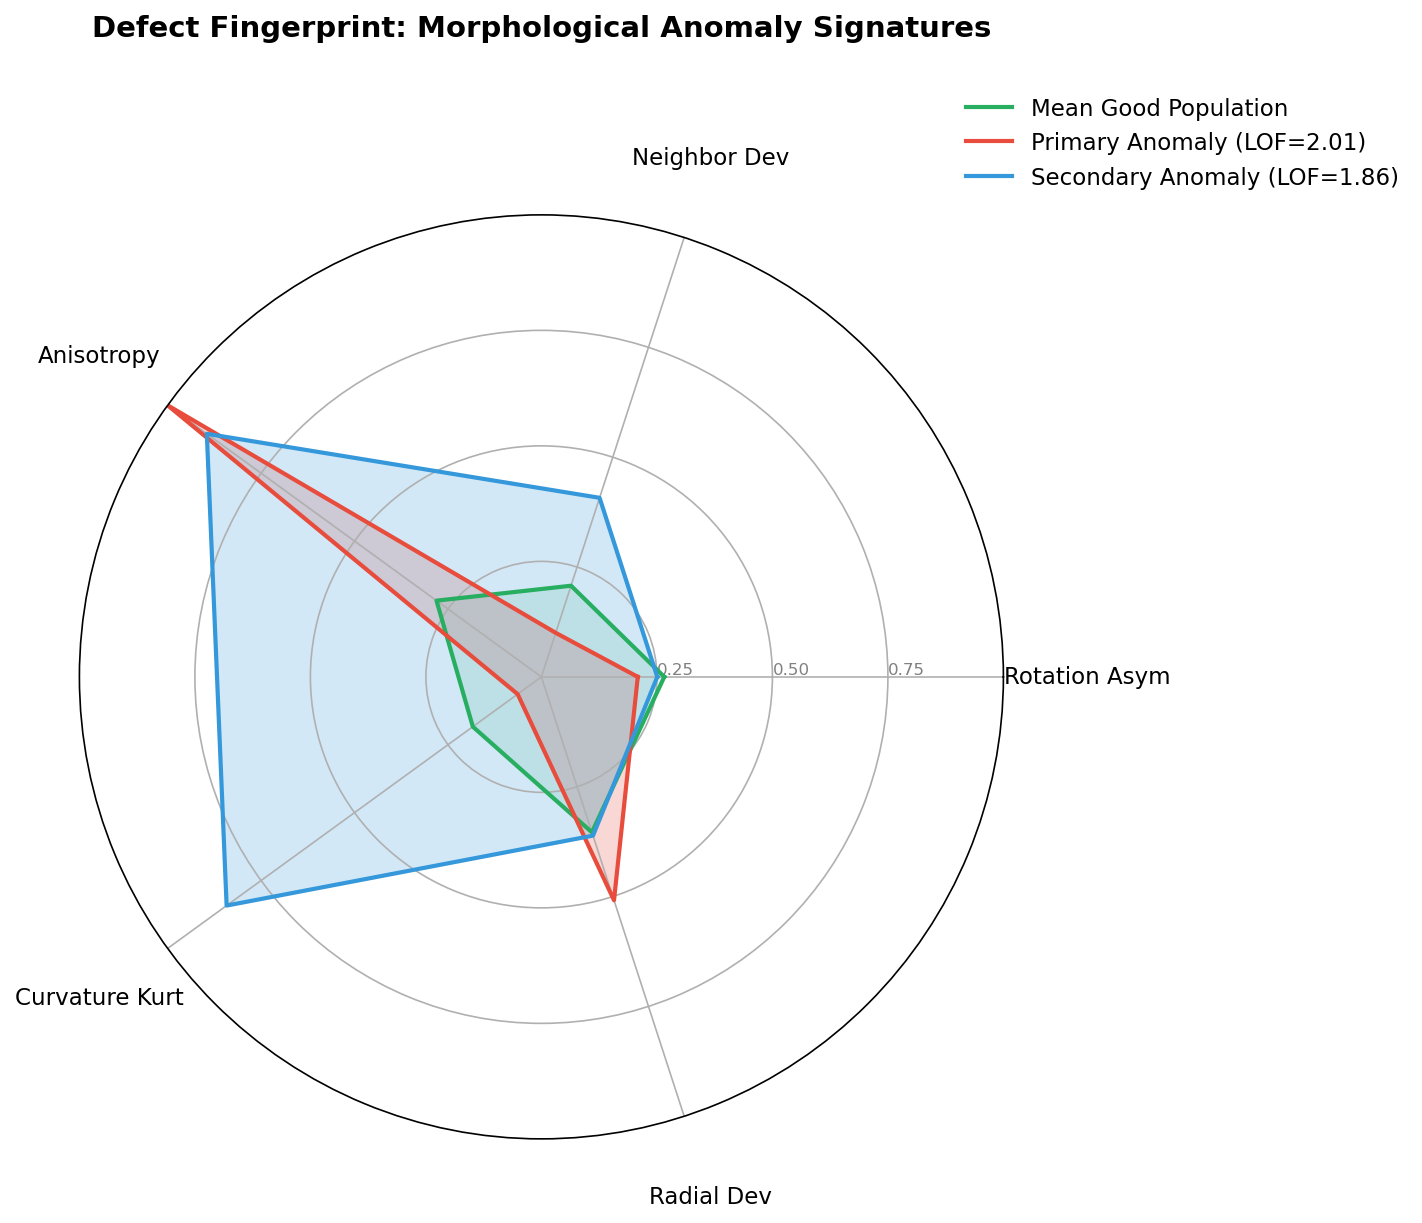

In [ ]:
def render_radar(df, idxs, names, colors):
    # Max-scale for visualization transparency
    data = df[cols].copy()
    data = (data - data.min()) / (data.max() - data.min() + 1e-10)
    avg_good = data[df['Label'] == 'Good'].mean()
    
    categories = [c.replace('_', ' ') for c in cols]
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    fig = plt.figure(figsize=(10, 8), dpi=150)
    ax = fig.add_subplot(111, polar=True)
    
    # --- Push category labels outward ---
    ax.set_thetagrids(
        [a * 180 / pi for a in angles[:-1]],
        labels=categories,
        fontsize=11
    )
    ax.tick_params(axis='x', pad=30)  # <<< key spacing fix
    
    # Base Good Population
    v_good = avg_good.tolist(); v_good += v_good[:1]
    ax.plot(angles, v_good, color='#27ae60', linewidth=2, label='Mean Good Population')
    ax.fill(angles, v_good, color='#27ae60', alpha=0.12)
    
    # Specific Outliers
    for idx, name, col in zip(idxs, names, colors):
        vals = data.iloc[idx].tolist(); vals += vals[:1]
        ax.plot(
            angles, vals,
            color=col, linewidth=2,
            label=f"{name} (LOF={df.iloc[idx]['LOF']:.2f})"
        )
        ax.fill(angles, vals, color=col, alpha=0.22)
    
    # Radial ticks
    ax.set_rlabel_position(0)
    plt.yticks(
        [0.25, 0.5, 0.75],
        ["0.25", "0.50", "0.75"],
        color="grey", size=8
    )
    plt.ylim(0, 1)
    

    
    # --- Move legend further right ---
    plt.legend(
        loc='upper right',
        bbox_to_anchor=(1.45, 1.15),
        frameon=False
    )
    
    plt.savefig(RESULTS_DIR / 'layer4_radar_fingerprints.png',
                dpi=200, bbox_inches='tight')
    plt.show()
# Find top and second top outliers for contrast
top_2 = df['LOF'].nlargest(2).index
render_radar(df, top_2, ['Primary Anomaly', 'Secondary Anomaly'], ['#e74c3c', '#3498db'])

## Plot 3: Sigma Deviation Heatmap
**Narrative:** Quantifying the 'strength' of the detection. Many irregular pillars are >5 standard deviations away from the norm in multiple dimensions.

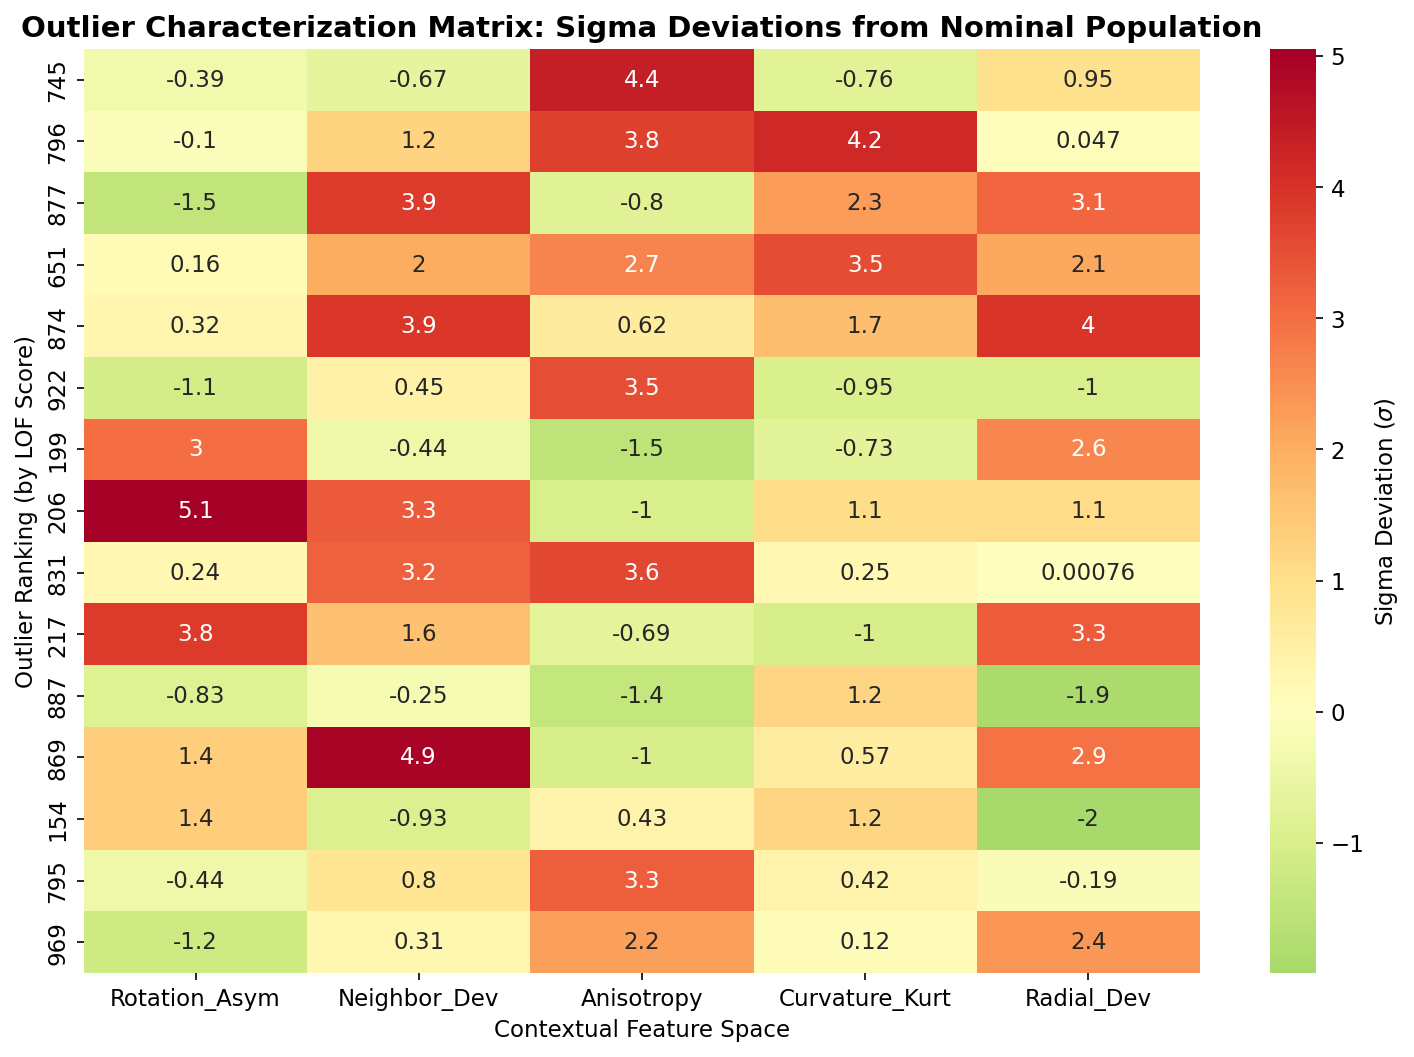

In [ ]:
good_stats = df[df['Label'] == 'Good'][cols]
sigma_devs = (df[cols] - good_stats.mean()) / good_stats.std()

top_outliers = df['LOF'].nlargest(15).index
z_subset = sigma_devs.loc[top_outliers]

plt.figure(figsize=(12, 8))
sns.heatmap(z_subset, annot=True, cmap='RdYlGn_r', center=0, cbar_kws={'label': 'Sigma Deviation ($\\sigma$)'})
plt.title('Outlier Characterization Matrix: Sigma Deviations from Nominal Population')
plt.xlabel('Contextual Feature Space')
plt.ylabel('Outlier Ranking (by LOF Score)')
plt.savefig(RESULTS_DIR / 'layer4_sigma_heatmap.png')
plt.show()

## Plot 4: The Anomaly Spectrum (Empirical CDF)
**Narrative:** Shows that while most of the population is stable (low LOF), there is a distinct and continuous transition into the defect regime.

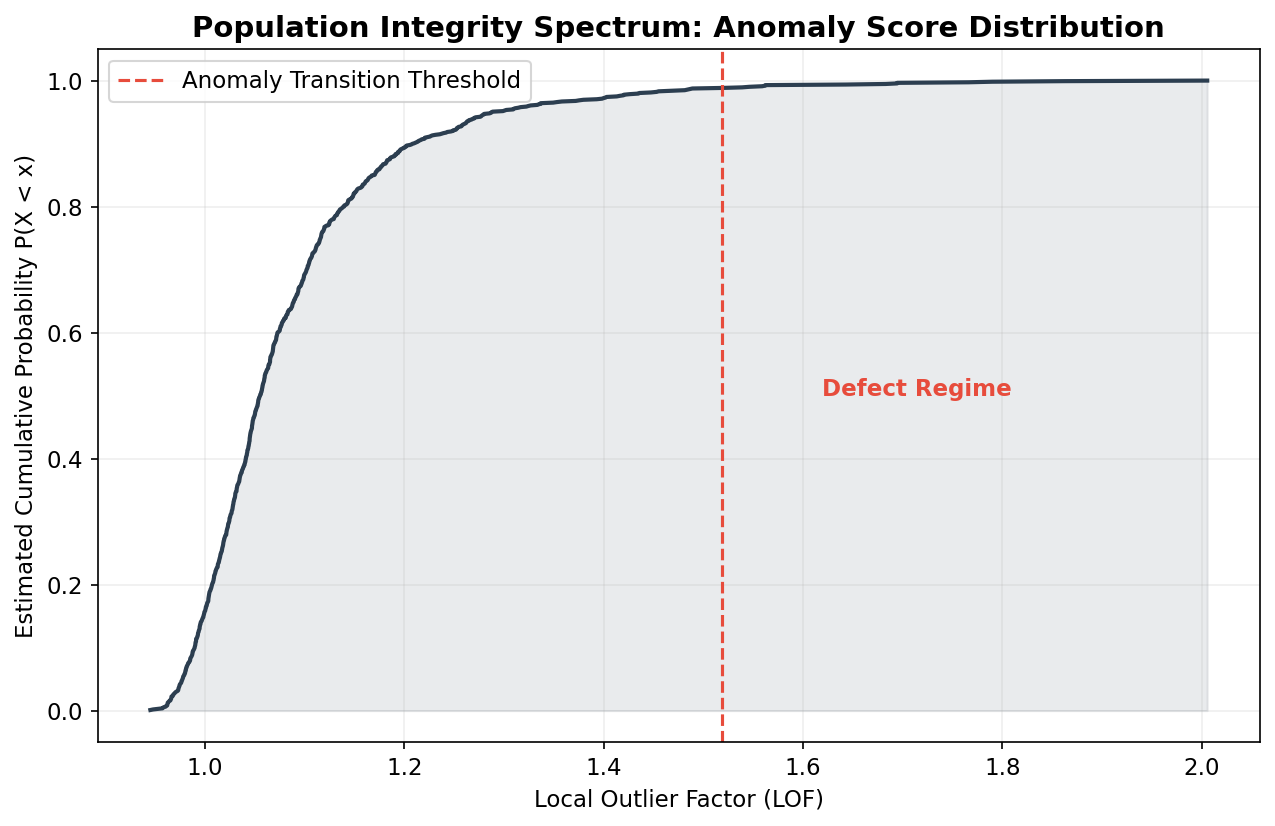

In [ ]:
sorted_lof = np.sort(df['LOF'])
y = np.arange(1, len(sorted_lof) + 1) / len(sorted_lof)

plt.figure(figsize=(10, 6))
plt.plot(sorted_lof, y, color='#2c3e50', lw=2)
plt.fill_between(sorted_lof, y, color='#2c3e50', alpha=0.1)

# Highlight regime transition
thresh = df[df['Label'] == 'Irregular']['LOF'].min()
plt.axvline(thresh, color='#e74c3c', ls='--', label='Anomaly Transition Threshold')
plt.annotate(f'Defect Regime', xy=(thresh+0.1, 0.5), color='#e74c3c', fontweight='bold')

plt.title('Population Integrity Spectrum: Anomaly Score Distribution')
plt.xlabel('Local Outlier Factor (LOF)')
plt.ylabel('Estimated Cumulative Probability P(X < x)')
plt.grid(alpha=0.2)
plt.legend()
plt.savefig(RESULTS_DIR / 'layer4_spectrum_cdf.png')
plt.show()

## Plot 5: Comparative Morphology Gallery
**Narrative:** Visualizing the outliers to confirm the 'sub-threshold' nature of the defects detected by Layer 4.

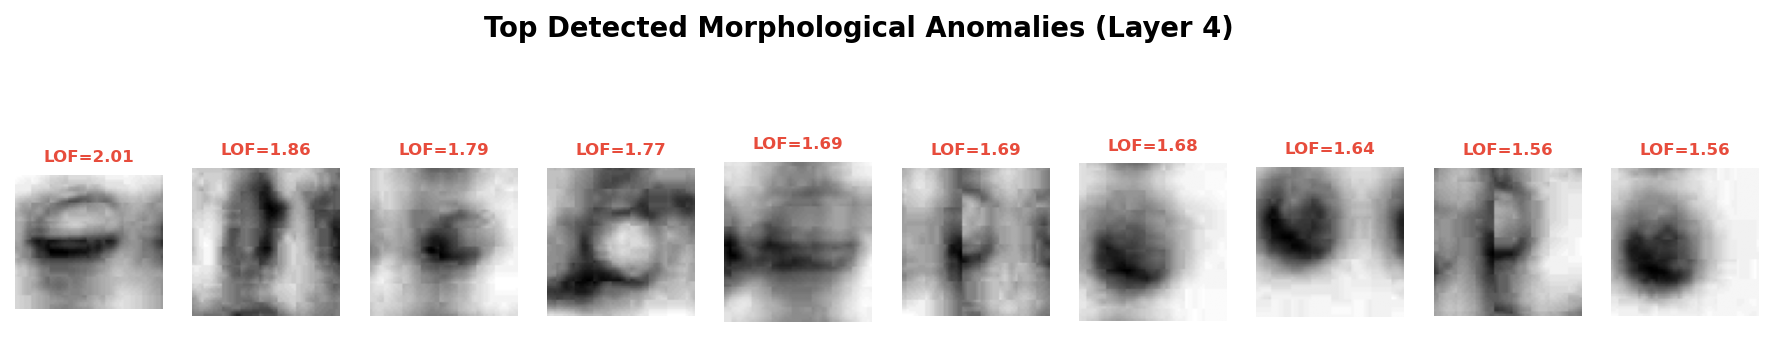

In [ ]:
top_idxs = df['LOF'].nlargest(10).index
fig, axes = plt.subplots(1, 10, figsize=(15, 2.5))
for i, idx in enumerate(top_idxs):
    axes[i].imshow(current_tiles[idx].image, cmap='gray')
    axes[i].set_title(f"LOF={df.iloc[idx]['LOF']:.2f}", fontsize=8, color='#e74c3c')
    axes[i].axis('off')
plt.suptitle('Top Detected Morphological Anomalies (Layer 4)', y=1.1, fontweight='bold')
plt.show()